In [24]:
#Import packages etc
import os
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import datetime
from paramsgen import *

In [17]:
def read_csv_files(directory):
    csv_files = []
    # print(f"Checking files in directory: {directory}")
    for filename in os.listdir(directory):
        if filename.startswith("sub") and filename.endswith(".csv"):
            print(f"Reading CSV file: {filename}")
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)
            csv_files.append(df)
        else:
            print(f"Skipping file: {filename}")
    return csv_files

def map_prolific_ids(dataframe):
    unique_ids = dataframe['prolific_id'].unique()
    id_mapping = {id: (i % 100) + 1 for i, id in enumerate(unique_ids)}
    dataframe['prolific_id'] = dataframe['prolific_id'].map(id_mapping)
    return dataframe, id_mapping


In [18]:
# Get data
current_directory = os.getcwd()
data_directory = os.path.join(current_directory, 'data')

# Load the task data only once
task_data_path = os.path.join(data_directory, 'task_data_nobehav.csv')
if os.path.exists(task_data_path):
    task_data = pd.read_csv(task_data_path)
    # print(task_data.head())

# Call the function and get the list of dataframes
dataframes = read_csv_files(data_directory)

# Ensure task_data is not included in the dataframes list
dataframes = [df for df in dataframes if not df.equals(task_data)]

# Display the first few rows of each DataFrame and the 'effLevel' column
# for i, df in enumerate(dataframes):
    # print(f"First few rows of DataFrame {i+1}:")
    # print(df.head())

# Concatenate all DataFrames into one
big_dataframe = pd.concat(dataframes, ignore_index=True)

# Get current date and time
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
id_mapping_df_var_name = f"id_mapping_df_{current_time}"

# Map prolific_id to numbers 1-100
big_dataframe, id_mapping_df = map_prolific_ids(big_dataframe)
# Delete all rows from big_dataframe where effLevel is NaN
big_dataframe = big_dataframe.dropna(subset=['effLevel'])
big_dataframe.to_csv(os.path.join(data_directory, 'big_dataframe.csv'), index=False)
big_dataframe = big_dataframe.dropna(subset=['trials.thisN'])
big_dataframe = big_dataframe.dropna(axis=1, how='all')
print(big_dataframe['Points'], big_dataframe['effLevel'],
      big_dataframe['percentage of bar reached'])
big_dataframe.to_csv(os.path.join(data_directory, 'big_dataframe.csv'), index=False)

Reading CSV file: sub-66a8029007c122fe8086afcb_rewardeffortlearning_2024-09-06_11h17.22.698.csv
Skipping file: sub-6547bf8012d4702680d55663_rewardeffortlearning_2024-09-06_10h30.03.678.log.gz
Reading CSV file: sub-55bd8669fdf99b5bfc7d4cfc_rewardeffortlearning_2024-09-06_11h25.07.641.csv
Reading CSV file: sub-63474e67a5fd298c6103c409_rewardeffortlearning_2024-09-06_10h50.53.039.csv
Reading CSV file: sub-5cba9a8a214b1a0016ccf708_rewardeffortlearning_2024-09-06_08h21.17.302.csv
Skipping file: sub-601b28841ca7bb2f8edaa293_rewardeffortlearning_2024-09-06_11h16.31.372.log.gz
Skipping file: PARTICIPANT_RewardEffortLearning_pilot2_2024-09-06_11h56.00.479.log.gz
Skipping file: .DS_Store
Skipping file: PARTICIPANT_RewardEffortLearning_pilot2_2024-09-06_11h53.27.161.csv
Skipping file: sub-66706a23c37c6099480f039d_rewardeffortlearning_2024-09-06_11h17.32.305.log.gz
Skipping file: sub-600319e3a3b1a337cab57a3e_rewardeffortlearning_2024-09-06_11h19.10.675.log.gz
Skipping file: sub-6333926e48c34a5d393

In [19]:
# Adapt the task_data to match the simulation scripts
task_data.rename(columns={'Points': 'reward', 'effLevel': 'threshold', 'prolific_id':'id',
                          'percentage of bar reached':'chosen_effort'}, inplace=True)
task_data = task_data[['reward', 'threshold']]
print(task_data.head())

   reward  threshold
0       2         48
1       2         63
2       0         50
3       0         27
4       1         24


In [20]:
def normalize_column_to_0_100(dataframe, column_name):
    """
    Rescale the indicated column to [0..100].
    """
    min_val = dataframe[column_name].min()
    max_val = dataframe[column_name].max()
    scaled = 100.0 * (dataframe[column_name] - min_val) / (max_val - min_val)
    return scaled


In [21]:
class RewardLearner:
    """
    Simple Rescorla-Wagner:
      R_hat[t] = R_hat[t-1] + alpha_r * (R_t - R_hat[t-1])
    """
    def __init__(self, alpha_r=0.1, init_reward=3.5, sigma_r=0.7):
        self.alpha_r = alpha_r
        self.R_hat = init_reward
        self.sigma_r = sigma_r
    
    def update(self, received_reward):
        delta_r = received_reward - self.R_hat
        self.R_hat += self.alpha_r * delta_r
        return self.R_hat
    
    def belief_distribution(self):
        return norm(loc=self.R_hat, scale=self.sigma_r)


class EffortLearner:
    """
    Direct threshold feedback:
      E_hat[t+1] = E_hat[t] + alpha_e * (theta[t] - E_hat[t])
    """
    def __init__(self, alpha_e=0.1, init_effort=50.0):
        self.alpha_e = alpha_e
        self.E_hat = init_effort
    
    def update(self, true_threshold):
        # E_hat and threshold in [0..100]
        delta_e = true_threshold - self.E_hat
        self.E_hat += self.alpha_e * delta_e
        self.E_hat = np.clip(self.E_hat, 0, 100)
        return self.E_hat


class EffortDiscounter:
    """
    We search e in [0..100], compute:
      p_success(e) = norm.cdf((e - E_hat)/sigma)
      SV(e) = R_hat - kappa*e
      EU(e) = SV(e)*p_success(e)
    Then either argmax or softmax.
    """
    def __init__(self, kappa=0.05, sigma=5.0, beta=5.0, policy='argmax'):
        self.kappa = kappa
        self.sigma = sigma
        self.beta = beta
        self.policy = policy

    def choose_effort(self, R_hat, E_hat):
        # Enumerate integer efforts from 0..100
        e_values = np.arange(101)
        EU_values = []

        for e in e_values:
            p_success = norm.cdf((e - E_hat)/self.sigma)
            SV = R_hat - self.kappa * e
            EU = SV * p_success
            EU_values.append(EU)

        EU_values = np.array(EU_values)
        if self.policy == 'argmax':
            chosen_e = e_values[np.argmax(EU_values)]
        else:
            # softmax sampling
            max_eu = np.max(EU_values)
            exp_vals = np.exp(self.beta * (EU_values - max_eu))
            probs = exp_vals / np.sum(exp_vals)
            chosen_e = np.random.choice(e_values, p=probs)

        print(f"Chosen effort: {chosen_e}")
        return chosen_e


In [22]:
def simulate_experiment(num_trials=60,
                        reward_learner_params=None,
                        effort_learner_params=None,
                        discounter_params=None,
                        data=None,
                        ignore_zero_reward=True,
                        normalize_reward=False,
                        normalize_effort=False):

    if reward_learner_params is None:
        reward_learner_params = {}
    if effort_learner_params is None:
        effort_learner_params = {}
    if discounter_params is None:
        discounter_params = {}

    # If your reward was originally 1..7 and you want to keep it that way, don't normalize it.
    # If you want it in 0..1, do the standard min-max scaling here.
    if normalize_reward:
        if ignore_zero_reward:
            data['reward'] = data['reward'].replace(0, np.nan)
  
        min_r = data['reward'].min()
        max_r = data['reward'].max()
        data['reward'] = (data['reward'] - min_r) / (max_r - min_r)

    if normalize_effort:
        data['threshold'] = normalize_column_to_0_100(data, 'threshold')

    RL = RewardLearner(**reward_learner_params)
    EL = EffortLearner(**effort_learner_params)
    discounter = EffortDiscounter(**discounter_params)

    results = {
        'trial': [],
        'threshold': [],
        'reward': [],
        'chosen_effort': [],
        'outcome': [],
        'R_hat': [],
        'E_hat': []
    }

    # Make sure we don't iterate beyond the size of 'data'
    actual_num_trials = min(num_trials, len(data))

    for t in range(1, actual_num_trials + 1):
        threshold = data.iloc[t-1]['threshold']
        reward = data.iloc[t-1]['reward']

        # Skip zero-reward trials if user requested
        if ignore_zero_reward and reward == 0:
            print(f"Trial {t}: Skipping zero-reward trial")
            continue

        # Current estimates
        R_hat_t = RL.R_hat
        E_hat_t = EL.E_hat

        # Discounter chooses an effort
        chosen_e = discounter.choose_effort(R_hat_t, E_hat_t)

        # Probability of success
        p_success = norm.cdf((chosen_e - E_hat_t)/discounter.sigma)
        outcome = np.random.binomial(1, p_success)
        received_reward = reward if outcome == 1 else 0.0

        # Update learners
        RL.update(received_reward)
        EL.update(threshold)

        print(f"Trial {t}: threshold={threshold:.2f}, reward={reward:.2f}, "
              f"chosen_e={chosen_e}, outcome={outcome}, "
              f"R_hat={RL.R_hat:.2f}, E_hat={EL.E_hat:.2f}")

        results['trial'].append(t)
        results['threshold'].append(threshold)
        results['reward'].append(reward)
        results['chosen_effort'].append(chosen_e)
        results['outcome'].append(outcome)
        results['R_hat'].append(RL.R_hat)
        results['E_hat'].append(EL.E_hat)

    return results

Chosen effort: 64
Trial 1: threshold=40.00, reward=2.00, chosen_e=64, outcome=1, R_hat=2.50, E_hat=42.00
Chosen effort: 55
Trial 2: threshold=61.43, reward=2.00, chosen_e=55, outcome=1, R_hat=2.25, E_hat=57.54
Trial 3: Skipping zero-reward trial
Trial 4: Skipping zero-reward trial
Chosen effort: 71
Trial 5: threshold=5.71, reward=1.00, chosen_e=71, outcome=1, R_hat=1.62, E_hat=16.08
Trial 6: Skipping zero-reward trial
Trial 7: Skipping zero-reward trial
Chosen effort: 29
Trial 8: threshold=44.29, reward=4.00, chosen_e=29, outcome=1, R_hat=2.81, E_hat=38.64
Trial 9: Skipping zero-reward trial
Trial 10: Skipping zero-reward trial
Chosen effort: 52
Trial 11: threshold=70.00, reward=5.00, chosen_e=52, outcome=1, R_hat=3.91, E_hat=63.73
Trial 12: Skipping zero-reward trial
Trial 13: Skipping zero-reward trial
Chosen effort: 78
Trial 14: threshold=92.86, reward=5.00, chosen_e=78, outcome=1, R_hat=4.45, E_hat=87.03
Chosen effort: 100
Trial 15: threshold=94.29, reward=5.00, chosen_e=100, outco

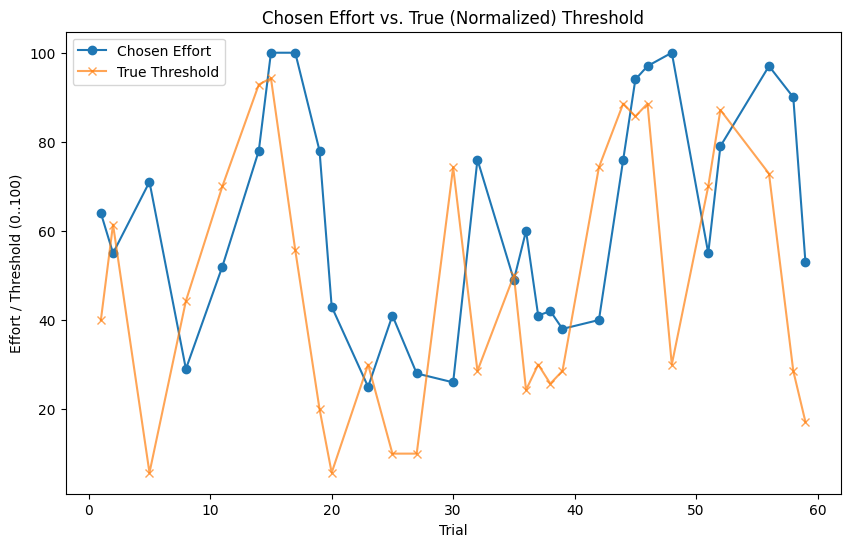

In [23]:
def main():
    # Example: we keep reward in [1..7], so normalize_reward=False.
    # We put threshold into [0..100], so normalize_effort=True.
    # Then we adopt kappa=0.05, sigma=5.0, so high efforts aren't always too costly.

    discounter_params = {
        'kappa': 0.005,   # Lower cost per unit effort
        'sigma': 5.0,    # Large enough for 0..100 scale
        'beta': 0.0,     # "Argmax" policy, so beta doesn't matter much
        'policy': 'argmax'
    }

    sim_results = simulate_experiment(
        num_trials=60,  # or len(task_data)
        reward_learner_params={'alpha_r': 0.5, 'init_reward': 3.0},
        effort_learner_params={'alpha_e': 0.8, 'init_effort': 50.0},
        discounter_params=discounter_params,
        data=task_data,
        ignore_zero_reward=True,
        normalize_reward=False,
        normalize_effort=True
    )

    # Quick plot: chosen_effort & threshold
    results_df = pd.DataFrame(sim_results)
    trials = results_df['trial']
    chosen_effort = results_df['chosen_effort']
    threshold = results_df['threshold']

    plt.figure(figsize=(10,6))
    plt.plot(trials, chosen_effort, label='Chosen Effort', marker='o')
    plt.plot(trials, threshold, label='True Threshold', marker='x', alpha=0.7)
    plt.xlabel('Trial')
    plt.ylabel('Effort / Threshold (0..100)')
    plt.title('Chosen Effort vs. True (Normalized) Threshold')
    plt.legend()
    plt.show()

# -------------------------------
# 8) Run main
# -------------------------------
if __name__ == "__main__":
    main()

Below are real data simulations and parameter recovery

In [25]:
def model_nll(params, subdf):
    """
    model_nll: Compute the negative log-likelihood under the
               effort–reward model for one participant's data.

    params = [alpha_r, alpha_e, kappa, sigma, beta]
        alpha_r : reward learning rate
        alpha_e : effort learning rate
        kappa   : cost rate per unit effort
        sigma   : noise/uncertainty scale in success probability
        beta    : inverse temperature (softmax)
    
    subdf is a subset of the data for one participant, with columns:
        'threshold', 'reward', 'chosen_effort', (optional) 'outcome'

    Returns: nLL (float) = negative log-likelihood
    """

    alpha_r, alpha_e, kappa, sigma, beta = params

    # 1) Initialize hidden states:
    #    You might pick something in the typical range for your data.
    R_hat = 3.0   # e.g. midpoint if reward is ~1..7
    E_hat = 50.0  # e.g. midpoint if threshold is ~0..100

    # 2) Sort subdf by trial if not guaranteed
    #    (Important to ensure updates happen in chronological order)
    subdf = subdf.sort_values('trial', ascending=True)

    # 3) Prepare to accumulate negative log-likelihood
    nLL = 0.0
    eps = 1e-12   # floor for probabilities to avoid log(0)

    # 4) Iterate over each trial
    for _, row in subdf.iterrows():
        threshold_t   = row['threshold']
        reward_t      = row['reward']
        chosenEff_t   = row['chosen_effort']

        # -- Compute the model's probability distribution over e in 0..100 --
        e_values = np.arange(101)
        EU = np.zeros_like(e_values, dtype=float)

        for iE, eTest in enumerate(e_values):
            # p_success(e) = Phi( (e - E_hat)/sigma )
            p_succ = norm.cdf((eTest - E_hat) / sigma)
            # SV(e) = R_hat - kappa*e
            SV = R_hat - kappa*eTest
            # EU(e) = SV(e) * p_success(e)
            EU[iE] = SV * p_succ

        # -- Softmax over EU to get choice probabilities --
        #    This is critical so that every possible effort has a probability > 0
        #    (Argmax would cause p=1 for the max and p=0 for others, which is
        #    not friendly for gradient-based fitting.)
        EU_max = np.max(EU)
        expEU = np.exp(beta*(EU - EU_max))  # subtract max for numerical stability
        p_e = expEU / np.sum(expEU)

        # Probability of the observed chosen effort
        if chosenEff_t in e_values:
            chosen_idx = int(chosenEff_t)
            p_chosen = p_e[chosen_idx]
        else:
            # If the participant's chosen effort isn't in 0..100 or not an integer
            # handle gracefully
            p_chosen = eps

        # Accumulate negative log-likelihood
        nLL -= np.log(max(p_chosen, eps))

        # -- Outcome handling --
        # If your data includes an 'outcome' column, let's read it:
        if 'outcome' in subdf.columns:
            outcome = row['outcome']
        else:
            # or simulate outcome from the model's p_succ at the chosen effort:
            p_succ_obs = norm.cdf((chosenEff_t - E_hat) / sigma)
            outcome = 1 if (np.random.rand() < p_succ_obs) else 0

        # The participant receives 'reward_t' only if outcome == 1
        received_reward = reward_t if outcome == 1 else 0.0

        # -- Update the learners --
        # Reward learner: R_hat <- R_hat + alpha_r * (received_reward - R_hat)
        delta_r = received_reward - R_hat
        R_hat   = R_hat + alpha_r * delta_r

        # Effort learner: E_hat <- E_hat + alpha_e * (threshold_t - E_hat)
        delta_e = threshold_t - E_hat
        E_hat   = E_hat + alpha_e * delta_e
        # Clip E_hat to [0,100]
        E_hat   = np.clip(E_hat, 0, 100)

    return nLL


def fit_participant(subdf, init_params=None, bounds=None):
    """
    fit_participant: Minimizes negative log-likelihood for one participant
    using scipy.optimize.minimize

    subdf: the DataFrame with all trials for a single participant
    init_params: optional starting guess [alpha_r, alpha_e, kappa, sigma, beta]
    bounds:      optional list of (min, max) for each param
    """

    if init_params is None:
        # [alpha_r, alpha_e, kappa, sigma, beta]
        init_params = [0.3, 0.3, 0.05, 5.0, 1.0]

    if bounds is None:
        # example bounds: alpha_r in [0,1], alpha_e in [0,1],
        #                 kappa in [0,1], sigma in [0.1,50], beta in [0,10]
        bounds = [(0,1), (0,1), (0,1), (0.1,50), (0,10)]

    # We'll minimize nLL with L-BFGS-B (supports bounds)
    res = minimize(fun=lambda x: model_nll(x, subdf),
                   x0=init_params,
                   bounds=bounds,
                   method='L-BFGS-B',
                   options={'maxfun':10000, 'disp':False})
    
    best_params = res.x
    best_nll    = res.fun
    return best_params, best_nll


def main():
    # 1) Load the long-format CSV
    df = big_dataframe
    
    # 2) Get unique participant IDs
    unique_ids = df['id'].unique()

    # 3) Container for results
    results_list = []

    # 4) Loop over participants
    for pid in unique_ids:
        subdf = df[df['id'] == pid].copy()

        # Fit the model to this participant
        best_params, best_nll = fit_participant(subdf)
        
        # best_params = [alpha_r, alpha_e, kappa, sigma, beta]
        results_dict = {
            'id': pid,
            'alpha_r': best_params[0],
            'alpha_e': best_params[1],
            'kappa':   best_params[2],
            'sigma':   best_params[3],
            'beta':    best_params[4],
            'nLL':     best_nll
        }
        results_list.append(results_dict)

        print(f"Participant {pid}: best_params={best_params}, nLL={best_nll:.3f}")
    
    # 5) Convert to DataFrame and save
    results_df = pd.DataFrame(results_list)
    print("\nFitting complete. Results:\n", results_df)
    results_df.to_csv('fit_results.csv', index=False)


if __name__ == "__main__":
    main()

KeyError: 'id'